In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as torch
from sklearn.manifold import TSNE

from splice.splice import SPLICE

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
torch.cuda.empty_cache()

### private angle

#### load model and data

In [3]:
train = np.load("../data/sprites/single-pose_private-angle_train.npz")
test = np.load("../data/sprites/single-pose_private-angle_test.npz")

In [97]:
A_train = torch.Tensor(train["view1"]).to(device).reshape(-1, 64*64*3)
B_train = torch.Tensor(train["view2"]).to(device).reshape(-1, 64*64*3)

A_test = torch.Tensor(test["view1"]).to(device).reshape(-1, 64*64*3)
B_test = torch.Tensor(test["view2"]).to(device).reshape(-1, 64*64*3)

In [91]:
test["angles"].shape

(5000, 2)

In [5]:
model = SPLICE(
    n_a=64 * 64 * 3,
    n_b=64 * 64 * 3,
    n_private_a=2,
    n_private_b=2,
    n_shared=500,
    conv=False,
    enc_layers = [1024, 512, 512, 2048, 1024, 512],
    dec_layers = [512, 1024, 2048, 512, 512, 1024],
    msr_layers = [512, 1024, 2048, 512, 512, 1024],
    size=None,
).to(device)

filepath = os.path.join("..","results", "models", "sprites", "isomap_splice_sprites_private-angle.pt")

model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [12]:
z_a, z_b2a, z_a2b, z_b, m_a2b, m_b2a, a_hat, b_hat = model(A_test, B_test)

z_a = z_a.cpu().detach().numpy()
z_b = z_b.cpu().detach().numpy()
z_a2b = z_a2b.cpu().detach().numpy()
z_b2a = z_b2a.cpu().detach().numpy()
a_hat = a_hat.cpu().detach().numpy()
b_hat = b_hat.cpu().detach().numpy()
A_test = A_test.cpu().detach().numpy()
B_test = B_test.cpu().detach().numpy()

In [7]:
mse = torch.nn.functional.mse_loss(a_hat, A_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(A_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/A_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((A_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ A_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.95615363

In [8]:
mse = torch.nn.functional.mse_loss(b_hat, B_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(B_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/B_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((B_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ B_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.95323414

#### plot private latent space vs angle

(-521.3043380737305, 411.52342376708987, -159.4832836151123, 561.9569850921631)

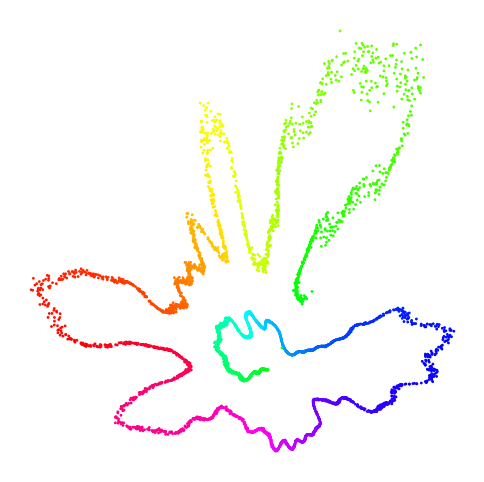

In [66]:
plt.figure(figsize=(6, 6))

test_angles = test["angles"]
plt.scatter(z_a[:, 0], z_a[:, 1], c=(test_angles[:,0]), s=1, cmap="hsv")
plt.axis("off")

# plt.savefig("../figures/isomap_sprites_private_angle_z_a.png", dpi=300, bbox_inches="tight")

(-17.940994366183297,
 377.9702344468588,
 -521.3043380737305,
 411.52342376708987)

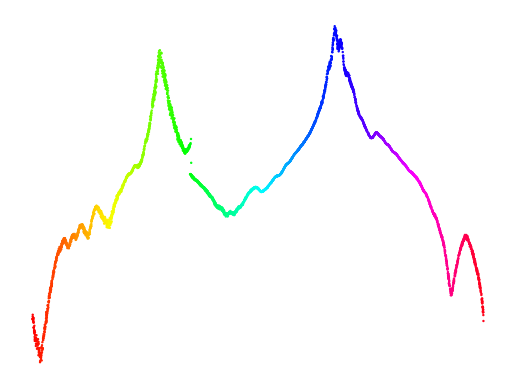

In [67]:
plt.scatter(test_angles[:,0], z_a[:,0], s=0.5,c=test_angles[:,0], cmap="hsv")
plt.axis("off")
# plt.savefig("../figures/isomap_sprites_private_angle_za_vs_theta.png", dpi=300, bbox_inches="tight")

(-17.940994366183297, 377.9702344468588, -159.4832836151123, 561.9569850921631)

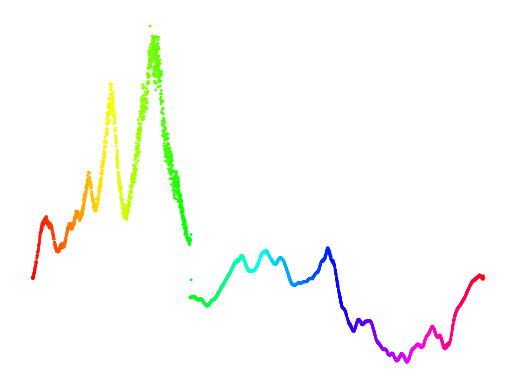

In [68]:
plt.scatter(test_angles[:,0], z_a[:,1], s=1, cmap="hsv", c =test_angles[:,0])
plt.axis("off")
# plt.savefig("../figures/isomap_sprites_private_angle_za1_vs_theta.png", dpi=300, bbox_inches="tight")

In [83]:
# Calculate variance explained by angle
angle_inds = np.argsort(test["angles"][:,0])
window_width = 28 # 0.5 degrees
var_1 = np.var(z_a[:,0])
var_2 = np.var(z_a[:,1])
std_1 = np.std(z_a[:,0])
std_2 = np.std(z_a[:,1])

window_vars_1 = []
window_vars_2 = []

for i in range(angle_inds.shape[0] - window_width):
    window_vars_1.append(np.var(z_a[angle_inds[i:i+window_width], 0]))
    window_vars_2.append(np.var(z_a[angle_inds[i:i+window_width], 1]))

window_vars_1 = np.array(window_vars_1)
window_vars_2 = np.array(window_vars_2)

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

# print(1-avg_var_1, 1-avg_var_2)
# print(1- np.sqrt(avg_var_1), 1- np.sqrt(avg_var_2))
print((var_1 * (1-avg_var_1) + var_2 * (1-avg_var_2))/(var_1 + var_2))
print((std_1 * (1-np.sqrt(avg_var_1)) + std_2 * (1-np.sqrt(avg_var_2)))/(std_1 + std_2))

0.9998641078148816
0.9883430017951793


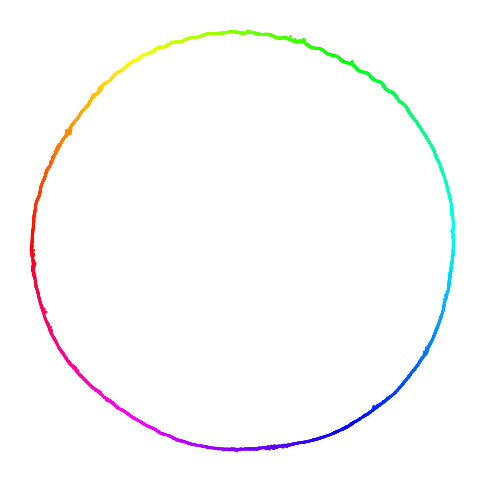

In [30]:
plt.figure(figsize=(6, 6))
test_angles = test["angles"]
plt.scatter(z_b[:, 0], z_b[:, 1], c=test_angles[:,1], s=1, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/isomap_sprites_private_angle_z_b.png", dpi=300, bbox_inches="tight")

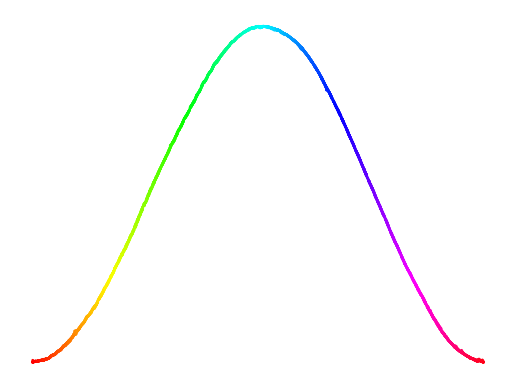

In [31]:
plt.scatter(test_angles[:,1], z_b[:,0], s=1, c=test_angles[:,1], cmap="hsv")
plt.axis("off")
plt.savefig("../figures/isomap_sprites_private_angle_zb0_vs_theta.png", dpi=300, bbox_inches="tight")

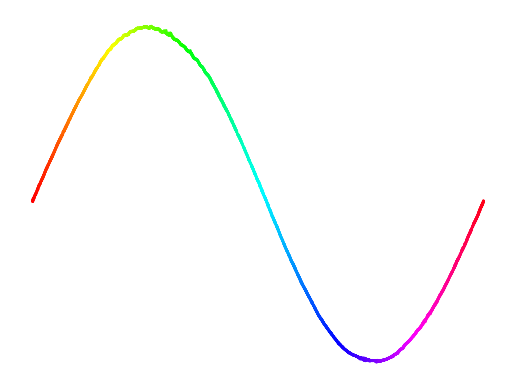

In [32]:
plt.scatter(test_angles[:,1], z_b[:,1], s=1, c=test_angles[:,1], cmap="hsv")
plt.axis("off")
plt.savefig("../figures/isomap_sprites_private_angle_zb1_vs_theta.png", dpi=300, bbox_inches="tight")

In [ ]:
# Calculate variance explained by angle
angle_inds = np.argsort(test["angles"][:,1])
window_width = 28 # 0.5 degrees
var_1 = np.var(z_b[:,0])
var_2 = np.var(z_b[:,1])

window_vars_1 = []
window_vars_2 = []

for i in range(angle_inds.shape[0] - window_width):
    window_vars_1.append(np.var(z_b[angle_inds[i:i+window_width], 0]))
    window_vars_2.append(np.var(z_b[angle_inds[i:i+window_width], 1]))

window_vars_1 = np.array(window_vars_1)
window_vars_2 = np.array(window_vars_2)

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

# print(1-avg_var_1, 1-avg_var_2)
# print(1- np.sqrt(avg_var_1), 1- np.sqrt(avg_var_2))
std_1 = np.std(z_b[:,0])
std_2 = np.std(z_b[:,1])
print((var_1 * (1-avg_var_1) + var_2 * (1-avg_var_2))/(var_1 + var_2))
print((std_1 * (1-np.sqrt(avg_var_1)) + std_2 * (1-np.sqrt(avg_var_2)))/(std_1 + std_2))


0.9998813137815767
0.9891040484544997


#### plot shared latent space

In [45]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
z_a2b_tsne = tsne.fit_transform(z_a2b)

In [46]:
test["inds"]

array([ 67, 121,  98, ...,  59,  26,  77])

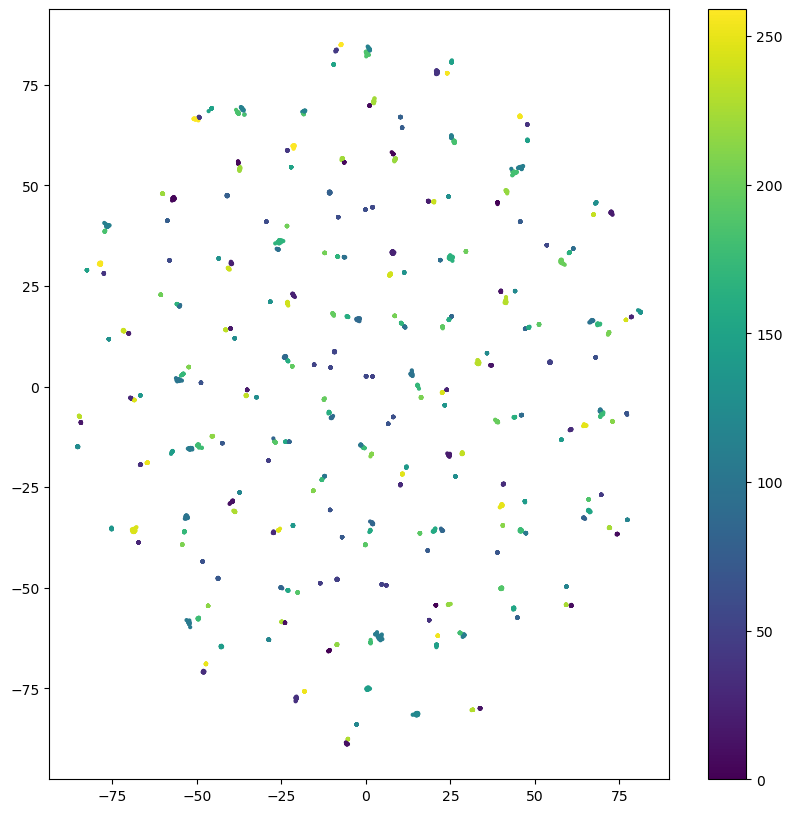

In [50]:
plt.figure(figsize=(10, 10))
test_angles = test["angles"]
plt.scatter(z_a2b_tsne[:, 0], z_a2b_tsne[:, 1], c=test["inds"], s=4)
plt.colorbar()

In [23]:
unique, inverse_inds = np.unique(test["inds"], return_inverse=True)
unique_inds = {}

for id in unique:
    unique_inds[unique[id]] = np.argwhere(inverse_inds == id).flatten()

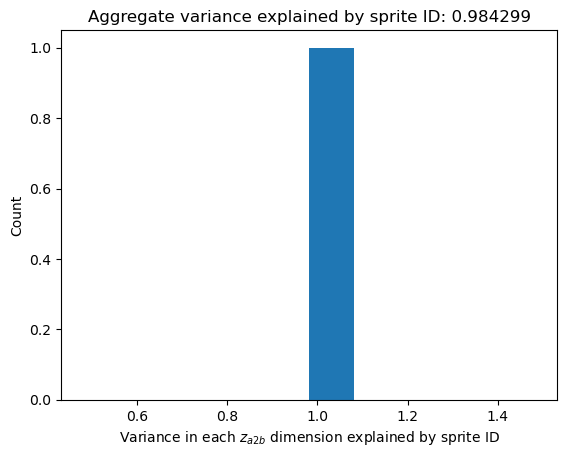

In [29]:
unexp_var_sprites = np.zeros((len(unique), 500))

for id in unique:
    unexp_var_sprites[id] = z_a2b[unique_inds[id]].var(axis=0) # variance within sprite, i.e. variance not explained by sprite id

percent_unexp_var_sprites = unexp_var_sprites / z_a2b.var(axis=0) # divide by total variance
percent_exp_var = 1 - np.sqrt(percent_unexp_var_sprites.mean(axis=0)) # for each sprite and dimension, how much variance is explained by sprite id

weighted_exp_var = (z_a2b.var(axis=0) * percent_exp_var).sum()/ z_a2b.var(axis=0).sum() # weight by total variance

# print(percent_exp_var.mean(axis=0))
plt.hist(percent_exp_var.mean(axis=0)); 
plt.xlabel(r"Variance in each $z_{a2b}$ dimension explained by sprite ID")
plt.ylabel("Count")
plt.title("Aggregate variance explained by sprite ID: %.6f" % weighted_exp_var);

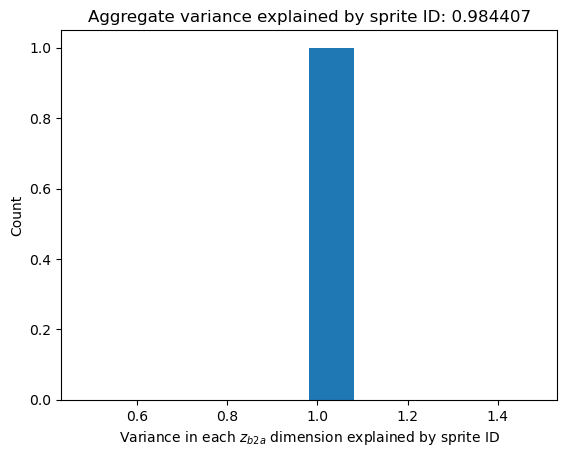

In [30]:
unexp_var_sprites = np.zeros((len(unique), 500))

for id in unique:
    unexp_var_sprites[id] = z_b2a[unique_inds[id]].var(axis=0) # variance within sprite, i.e. variance not explained by sprite id

percent_unexp_var_sprites = unexp_var_sprites / z_b2a.var(axis=0) # divide by total variance
percent_exp_var = 1 - np.sqrt(percent_unexp_var_sprites.mean(axis=0)) # for each sprite and dimension, how much variance is explained by sprite id

weighted_exp_var = (z_b2a.var(axis=0) * percent_exp_var).sum()/ z_b2a.var(axis=0).sum() # weight by total variance

# print(percent_exp_var.mean(axis=0))
plt.hist(percent_exp_var.mean(axis=0)); 
plt.xlabel(r"Variance in each $z_{b2a}$ dimension explained by sprite ID")
plt.ylabel("Count")
plt.title("Aggregate variance explained by sprite ID: %.6f" % weighted_exp_var);

#### plot reconstructions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

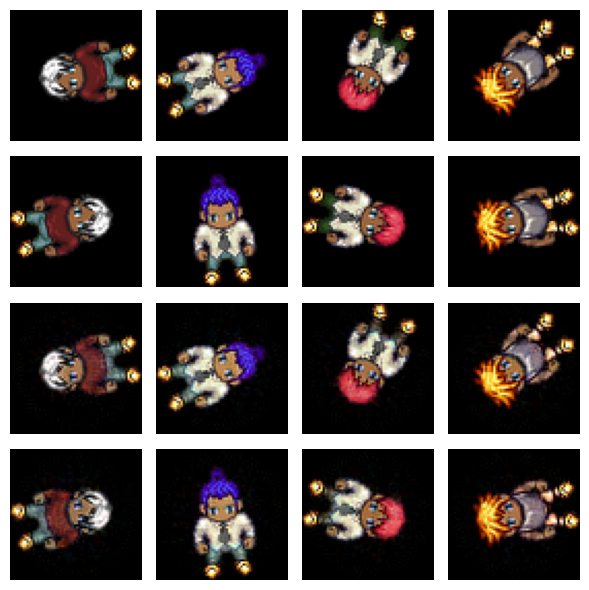

In [89]:
# inds = np.random.randint(0, 5000, 4)
inds = [499, 1996, 2551,  628]
plt.figure(figsize=(6,6))

for i in range(4):
    plt.subplot(4,4,i+1)
    plt.imshow(A_test[inds[i]].reshape(64,64,-3));
    plt.axis("off")

    plt.subplot(4,4,i+5)
    plt.imshow(B_test[inds[i]].reshape(64,64,-3));
    plt.axis("off")

    plt.subplot(4,4,i+9)
    plt.imshow(a_hat[inds[i]].reshape(64,64,-3));
    plt.axis("off")

    plt.subplot(4,4,i+13)
    plt.imshow(b_hat[inds[i]].reshape(64,64,-3));
    plt.axis("off")

plt.tight_layout()
plt.savefig("../figures/arxiv_figures/splice_sprite_recons.svg", transparent=True, dpi=300)


In [124]:
angles = [36, 108, 180, 252, 324]
angle_inds = []

for angle in angles:
    angle_inds.append(np.argsort(np.abs(test["angles"][:,1]-angle))[:5])

angle_inds = np.array(angle_inds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

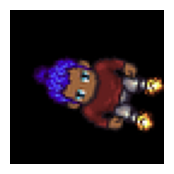

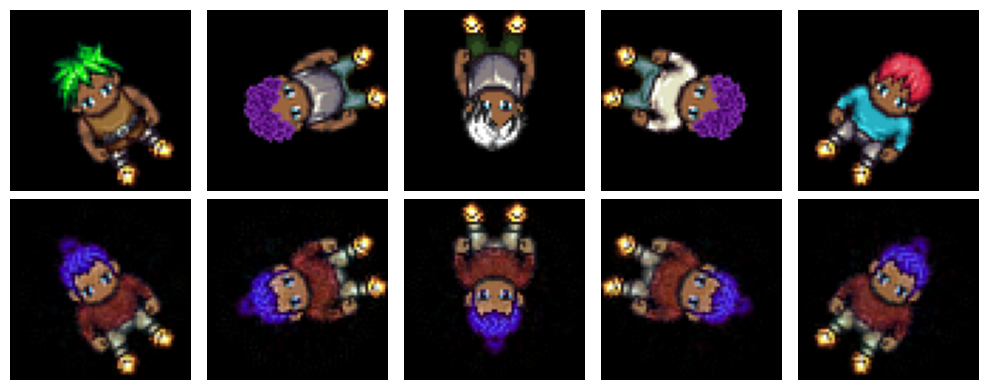

In [134]:
sprite_ind = 3642
z_a, z_b2a, z_a2b, z_b, m_a2b, m_b2a, a_hat, b_hat = model(A_test, B_test)

cross_lats = torch.hstack((z_b[angle_inds[:,2]], torch.tile(z_a2b[sprite_ind], (5,1))))
cross_recons = model.G_b(cross_lats).detach().cpu().numpy()

plt.figure(figsize=(2,2))
plt.imshow(A_test[sprite_ind].detach().cpu().numpy().reshape(64,64,-1))
plt.axis("off")

plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(B_test[angle_inds[i, 2]].detach().cpu().numpy().reshape(64,64,-1))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(cross_recons[i].reshape(64,64,-1))
    plt.axis("off")

plt.tight_layout()
plt.savefig("../figures/arxiv_figures/splice_sprite_cross_reconds.svg", transparent=True, dpi=300)

### shared angle

In [3]:
torch.cuda.empty_cache()
train = np.load("../data/sprites/single-pose_shared-angle_train.npz")
test = np.load("../data/sprites/single-pose_shared-angle_test.npz")

In [4]:
A_train = torch.Tensor(train["view1"]).to(device).reshape(-1, 64*64*3)
B_train = torch.Tensor(train["view2"]).to(device).reshape(-1, 64*64*3)

A_test = torch.Tensor(test["view1"]).to(device).reshape(-1, 64*64*3)
B_test = torch.Tensor(test["view2"]).to(device).reshape(-1, 64*64*3)

In [5]:
model = SPLICE(
    n_a=64 * 64 * 3,
    n_b=64 * 64 * 3,
    n_private_a=500,
    n_private_b=500,
    n_shared=2,
    conv=False,
    enc_layers = [1024, 512, 512, 2048, 1024, 512],
    dec_layers = [512, 1024, 2048, 512, 512, 1024],
    msr_layers = [512, 1024, 2048, 512, 512, 1024],
    size=None,
).to(device)

filepath = os.path.join("..","results", "models", "sprites", "isomap_splice_sprites_shared-angle.pt")

model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [6]:
z_a, z_b2a, z_a2b, z_b, m_a2b, m_b2a, a_hat, b_hat = model(A_test, B_test)

z_a = z_a.cpu().detach().numpy()
z_b = z_b.cpu().detach().numpy()
z_a2b = z_a2b.cpu().detach().numpy()
z_b2a = z_b2a.cpu().detach().numpy()

In [7]:
mse = torch.nn.functional.mse_loss(a_hat, A_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(A_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/A_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((A_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ A_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.75968

In [8]:
mse = torch.nn.functional.mse_loss(b_hat, B_test, reduction='none').mean(dim=0).cpu().detach().numpy()
nonzero = np.argwhere(B_test.var(dim=0).cpu().detach().numpy() > 0).flatten()

vars_unexp_raw = mse[nonzero]/B_test.var(dim=0).cpu().detach().numpy()[nonzero]

vars_exp = ((B_test.var(dim=0).cpu().detach().numpy()[nonzero] * (1 - vars_unexp_raw))).sum()/ B_test.var(dim=0).cpu().detach().numpy()[nonzero].sum()
vars_exp

0.81309414

#### plot latent space vs angle

(-182.32671890258788,
 388.5523506164551,
 -145.53292655944824,
 452.8130855560303)

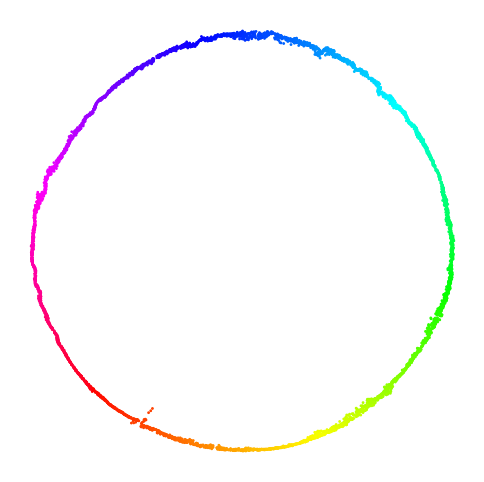

In [9]:
plt.figure(figsize=(6, 6))
test_angles = test["angles"]
plt.scatter(z_a2b[:, 0], z_a2b[:, 1], c=test_angles, s=1, cmap="hsv")
plt.axis("off")
# plt.savefig("../figures/isomap_sprites_shared_angle_z_a2b.png", dpi=300, bbox_inches="tight")

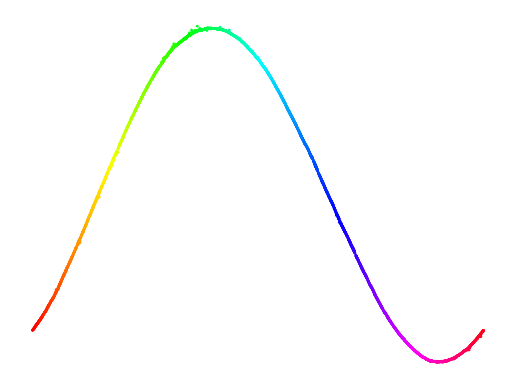

In [16]:
plt.scatter(test_angles, z_a2b[:,0], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/isomap_sprites_shared_angle_za2b_vs_theta.png", dpi=300, bbox_inches="tight")

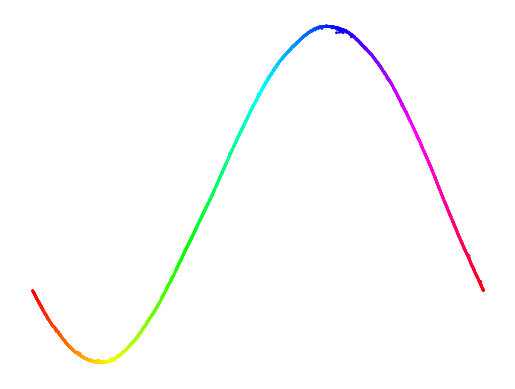

In [17]:
plt.scatter(test_angles, z_a2b[:,1], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/isomap_sprites_shared_angle_za2b1_vs_theta.png", dpi=300, bbox_inches="tight")

In [32]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles)
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_a2b[:,0])
var_2 = np.var(z_a2b[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles >= start) & (test_angles < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_a2b[angle_inds, 0]))
        window_vars_2.append(np.var(z_a2b[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print((1-avg_var_1 + 1-avg_var_2)/2)

0.9999450801406056


(-613.9242950439453, 305.3137603759766, -206.3114227294922, 308.6346038818359)

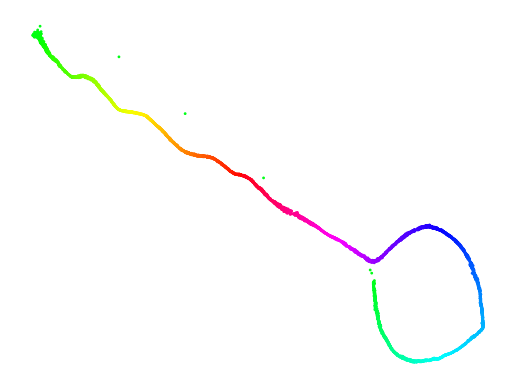

In [10]:
test_angles = test["angles"]
plt.scatter(z_b2a[:, 0], z_b2a[:, 1], c=test_angles, s=1, cmap="hsv")
plt.axis("off")
# plt.savefig("../figures/sprites_shared_angle_z_b2a.png", dpi=300, bbox_inches="tight")

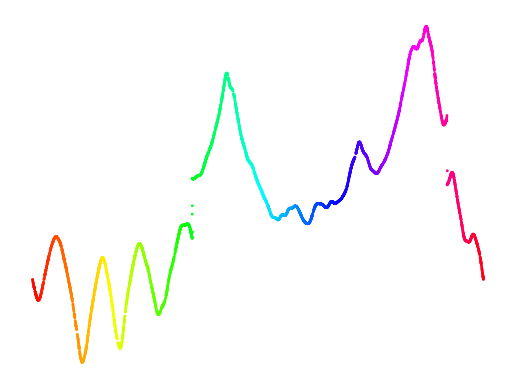

In [57]:
plt.scatter(test_angles, z_b2a[:,0], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_zb2a0_vs_theta.png", dpi=300, bbox_inches="tight")

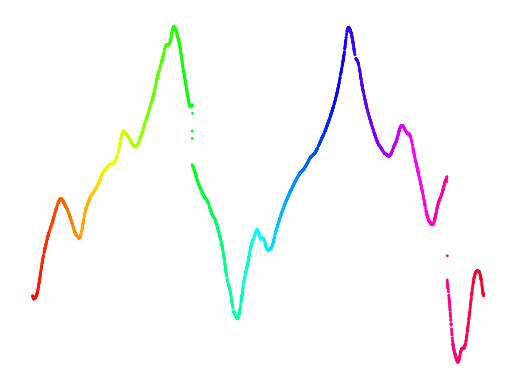

In [58]:
plt.scatter(test_angles, z_b2a[:,1], s=1, c=test_angles, cmap="hsv")
plt.axis("off")
plt.savefig("../figures/sprites_shared_angle_zb2a1_vs_theta.png", dpi=300, bbox_inches="tight")

In [59]:
# Calculate variance explained by angle
angle_inds = np.argsort(test_angles)
intervals = np.arange(0, 360, 0.5)

var_1 = np.var(z_b2a[:,0])
var_2 = np.var(z_b2a[:,1])

window_vars_1 = []
window_vars_2 = []
lens = []

for i in range(len(intervals)-2):
    start = intervals[i]
    end = intervals[i+2]
    angle_inds = np.argwhere((test_angles >= start) & (test_angles < end)).flatten()

    # print(i, start, end, len(angle_inds))

    if len(angle_inds > 1):
        window_vars_1.append(np.var(z_b2a[angle_inds, 0]))
        window_vars_2.append(np.var(z_b2a[angle_inds, 1]))

avg_var_1 = np.mean(window_vars_1)/var_1
avg_var_2 = np.mean(window_vars_2)/var_2

print(1-avg_var_1 , 1-avg_var_2)

0.9990585190826096 0.9986434209858999


#### plot reconstructions